In [1]:
import pandas as pd
import numpy as np
# 文件路径
file_path = r'E:\HJHCloud\Seafile\typhoon data\最佳路径数据集完整版\ibtracs.WP.list.v04r01.csv'
typhoon_track_data = pd.read_csv(file_path, low_memory=False)
typhoon_track_data = typhoon_track_data[200000:]
# 筛选 2013 年及以后的数据
data = typhoon_track_data[typhoon_track_data['SEASON'] >= '2013']
column_name = ['SEASON','NAME','ISO_TIME','NATURE','LAT','LON','USA_PRES']
typhoon_dict = {
    '2013': ['RUMBIA', 'UTOR', 'USAGI', 'KROSA'],
    '2014': ['RAMMASUN', 'KALMAEGI'],
    '2015': ['LINFA', 'MUJIGAE'],
    '2016': ['NIDA', 'HAIMA'],
    '2017': ['MERBOK', 'ROKE', 'HATO', 'PAKHAR', 'MAWAR', 'KHANUN'],
    '2018': ['GAEMI', 'SON-TINH', 'MANGKHUT', 'BARIJAT', 'YUTU'],
    '2019': ['WIPHA', 'BAILU'],
    '2020': ['MEKKHALA', 'HIGOS', 'NANGKA', 'SAUDEL', 'ATSANI'],
    '2021': ['CHOI-WAN', 'LUPIT', 'CHANTHU', 'KOMPASU'],
    '2022': ['CHABA', 'MULAN', 'MA-ON', 'NALGAE'],
    '2023': ['TALIM', 'SAOLA', 'KOINU'],
    '2024': ['MALIKSI', 'YAGI']
}

data = data[column_name]
typhoon_pairs = [(year, name) for year, names in typhoon_dict.items() for name in names]
typhoon_df = pd.DataFrame(typhoon_pairs, columns=['SEASON', 'NAME'])

# 步骤2：与原数据合并实现高效筛选
typhoon_data = pd.merge(data, typhoon_df, on=['SEASON', 'NAME'], how='inner')

In [2]:
# 地球平均半径（单位：km）
EARTH_RADIUS = 6371.0

# 定义 Haversine 公式计算距离
def haversine(lat1, lon1, lat2, lon2):
    """
    计算两个经纬度点之间的球面距离（单位：km）
    """
    # 将经纬度从度转换为弧度
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return EARTH_RADIUS * c


def map_relationship(distance, strength):
    """
    根据距离和强度映射关系：
    Type1: distance <50 km and strength=='DS'
    Type2: distance <50 km and strength=='TS'
    Type3: distance <50 km and strength=='ET'
    Type4: distance <50 km and strength=='SS'
    Type5: distance <50 km and strength=='NR'
    Type6: distance <50 km and strength=='MX'

    N: distance>200 km
    """
    # 强度到索引的映射表 (顺序严格对应类型编号)
    strength_order = ["DS", "TS", "ET", "SS", "NR", "MX"]

    # 检查强度是否有效
    if strength not in strength_order:
        return "N"

    # 计算基础类型编号
    if distance <= 50:
        base = 1
    elif 50 < distance <= 100:
        base = 7
    elif 100 < distance <= 150:
        base = 13
    elif 150 < distance <= 200:
        base = 19
    elif 200 < distance <= 250:
        base = 25
    elif 250 < distance <= 300:
        base = 31
    elif 300 < distance <= 350:
        base = 37
    else:
        return "N"

    # 根据强度计算最终类型
    return f"Type{base + strength_order.index(strength)}"

# 取整台风经纬度，映射为实体1
# 确保 LAT/LON 列是数值类型 (修复核心错误)
typhoon_data['LAT'] = pd.to_numeric(typhoon_data['LAT'], errors='coerce')
typhoon_data['LON'] = pd.to_numeric(typhoon_data['LON'], errors='coerce')

# 删除无效数据行
typhoon_data = typhoon_data.dropna(subset=['LAT', 'LON'])

# 执行取整操作 (基于修复后的数值类型)
typhoon_data['LAT_round'] = typhoon_data['LAT'].apply(lambda x: round(x * 2) / 2)
typhoon_data['LON_round'] = typhoon_data['LON'].apply(lambda x: round(x * 2) / 2)

# 创建Entity1（示例格式：23.5_122.0_TS）
typhoon_data['Entity1'] = (
    typhoon_data['LAT_round'].astype(str) + "_"
    + typhoon_data['LON_round'].astype(str) + "_"
    + typhoon_data['NATURE'].astype(str)
)

# 定义海上风电场的经纬度（实体2）
wind_farms = {
    'Farm16': (116.9930, 23.2692),
    'Farm9': (111.6650, 21.3390),
    'Farm4': (111.5119, 21.2624),
    'Farm14': (114.9953, 22.7061),
    'Farm0': (112.2365, 21.4908),
    'Farm7': (113.4310, 21.9120),
    'Farm10': (110.7611, 20.6272),
    'Farm17': (111.6640, 21.0136),
    'Farm6': (112.1678, 21.4469)
}

# 创建存储三元组的列表
triples = []

# 遍历每个台风记录和每个风电场，计算距离和关系
for _, row in typhoon_data.iterrows():
    lat1, lon1 = row['LAT'], row['LON']
    # # 如果 lat1, lon1 不在划定的范围内（假设范围为0-90纬度，0-180经度），跳过
    # if not (18 <= lat1 <= 23 and 110 <= lon1 <= 119):
    #     continue

    entity1 = row['Entity1']
    strength = row['NATURE']

    for farm_name, (lon2, lat2) in wind_farms.items():
        # 计算距离
        distance = haversine(lat1, lon1, lat2, lon2)
        # 映射关系
        relationship = map_relationship(distance, strength)
        # 添加三元组 (实体1, 关系, 实体2)
        triples.append((entity1, relationship, farm_name))

# 转换为 DataFrame 便于查看
triples_df = pd.DataFrame(triples, columns=['Entity1', 'Relationship', 'Entity2'])

In [3]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F  # 添加这行
import torch.optim as optim
from sklearn.model_selection import train_test_split
# 1. 提取三元组
triplets = triples_df[['Entity1', 'Relationship', 'Entity2']].values.tolist()

# 2. 创建实体和关系的映射
# 将所有实体和关系编码为索引
entities = set(triples_df['Entity1']).union(set(triples_df['Entity2']))
relations = set(triples_df['Relationship'])
entity2id = {entity: idx for idx, entity in enumerate(entities)}
relation2id = {relation: idx for idx, relation in enumerate(relations)}

# 将三元组转为索引形式
indexed_triplets = [
    [entity2id[head], relation2id[relation], entity2id[tail]]
    for head, relation, tail in triplets
]

# 转换为 Tensor
triplets_tensor = torch.tensor(indexed_triplets, dtype=torch.long)

# 4. 数据集拆分
train_triplets, test_triplets = train_test_split(triplets_tensor, test_size=0.1, random_state=42)

In [4]:
# 5. 使用 TransEModel 进行训练
class TransEModel(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim, margin=1.0, p=1):
        super(TransEModel, self).__init__()
        self.entity_embeddings = nn.Embedding(num_entities, embedding_dim)
        self.relation_embeddings = nn.Embedding(num_relations, embedding_dim)
        self.margin = margin
        self.p = p

        # 初始化嵌入
        nn.init.xavier_uniform_(self.entity_embeddings.weight.data)
        nn.init.xavier_uniform_(self.relation_embeddings.weight.data)

    def forward(self, positive_triplets, negative_triplets):
        pos_distance = self._distance(positive_triplets)
        neg_distance = self._distance(negative_triplets)
        return torch.relu(self.margin + pos_distance - neg_distance).mean()

    def _distance(self, triplets):
        head = F.normalize(self.entity_embeddings(triplets[:, 0]), p=2, dim=1)  # L2归一化
        relation = F.normalize(self.relation_embeddings(triplets[:, 1]), p=2, dim=1)
        tail = F.normalize(self.entity_embeddings(triplets[:, 2]), p=2, dim=1)
        return torch.norm(head + relation - tail, p=self.p, dim=1)


# 3. 生成负样本
def generate_negative_samples(triplets_tensor, num_entities):
    """
    生成负样本，通过随机替换头实体或尾实体。
    """
    negative_triplets = triplets_tensor.clone()
    for i in range(negative_triplets.size(0)):
        if torch.rand(1).item() > 0.5:  # 随机替换头实体
            new_head = torch.randint(0, num_entities, (1,))
            while new_head == negative_triplets[i, 0]:  # 确保新实体不同于原实体
                new_head = torch.randint(0, num_entities, (1,))
            negative_triplets[i, 0] = new_head
        else:  # 随机替换尾实体
            new_tail = torch.randint(0, num_entities, (1,))
            while new_tail == negative_triplets[i, 2]:  # 确保新实体不同于原实体
                new_tail = torch.randint(0, num_entities, (1,))
            negative_triplets[i, 2] = new_tail
    return negative_triplets

In [5]:
# 参数设置
fix_seed = 2024
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)
num_entities = len(entity2id)
num_relations = len(relation2id)
embedding_dim = 10
margin = 0.1

# 模型实例
model = TransEModel(num_entities, num_relations, embedding_dim, margin)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练步骤
epochs = 50
batch_size = 32
patience = 3  # 早停机制的耐心次数
best_loss = float('inf')
no_improvement = 0  # 记录连续未改善的次数

for epoch in range(epochs):
    model.train()
    total_loss = 0

    # 按批次训练
    model.train()
    for i in range(0, len(train_triplets), batch_size):
        positive_batch = train_triplets[i:i + batch_size]
        negative_batch = generate_negative_samples(positive_batch, num_entities)

        optimizer.zero_grad()
        loss = model(positive_batch, negative_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()*batch_size

    # 计算每个epoch的平均loss
    average_loss = total_loss / len(train_triplets)

    
    # 测试
    model.eval()
    with torch.no_grad():
        positive_test = test_triplets
        negative_test = generate_negative_samples(test_triplets, num_entities)
        test_loss = model(positive_test, negative_test)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {average_loss}, Test Loss: {test_loss.item()}")

    # 检查是否早停
    if average_loss < best_loss:
        best_loss = average_loss
        no_improvement = 0  # 重置计数器
        torch.save(model.state_dict(), 'best_transe_model.pth')  # 保存最优模型
    else:
        no_improvement += 1
        print(f"No improvement for {no_improvement} epochs.")

    if no_improvement >= patience:
        print("Early stopping triggered.")
        break

# 保存模型
torch.save(model.state_dict(), 'transe_model.pth')

Epoch 1/50, Train Loss: 0.17454108205691718, Test Loss: 0.09166286885738373
Epoch 2/50, Train Loss: 0.08981645827125355, Test Loss: 0.0893591120839119
Epoch 3/50, Train Loss: 0.08362652908806958, Test Loss: 0.08957713097333908
Epoch 4/50, Train Loss: 0.07348123326538748, Test Loss: 0.07638270407915115
Epoch 5/50, Train Loss: 0.07132721292571582, Test Loss: 0.07785848528146744
Epoch 6/50, Train Loss: 0.06990069507759585, Test Loss: 0.07313937693834305
Epoch 7/50, Train Loss: 0.06774225851137154, Test Loss: 0.06383714824914932
Epoch 8/50, Train Loss: 0.06407117108587398, Test Loss: 0.06509575247764587
Epoch 9/50, Train Loss: 0.06356253492419954, Test Loss: 0.06551095843315125
Epoch 10/50, Train Loss: 0.06111147688622575, Test Loss: 0.0683857798576355
Epoch 11/50, Train Loss: 0.06045712167521482, Test Loss: 0.06242332234978676
Epoch 12/50, Train Loss: 0.0579368385857173, Test Loss: 0.0647384375333786
Epoch 13/50, Train Loss: 0.05758885738450007, Test Loss: 0.06050289422273636
Epoch 14/50,

In [6]:
# 保存映射
import pickle

with open('entity2id.pkl', 'wb') as f:
    pickle.dump(entity2id, f)
with open('relation2id.pkl', 'wb') as f:
    pickle.dump(relation2id, f)


# 加载self.entity_embeddings
entity_embeddings = model.entity_embeddings.weight.data.numpy()
embedding = entity_embeddings[0]
print(embedding)

[-0.13417077 -0.14088333  0.08881152  0.14589803  0.17156143 -0.23794138
  0.12342475 -0.05247303  0.21851708 -0.02697994]


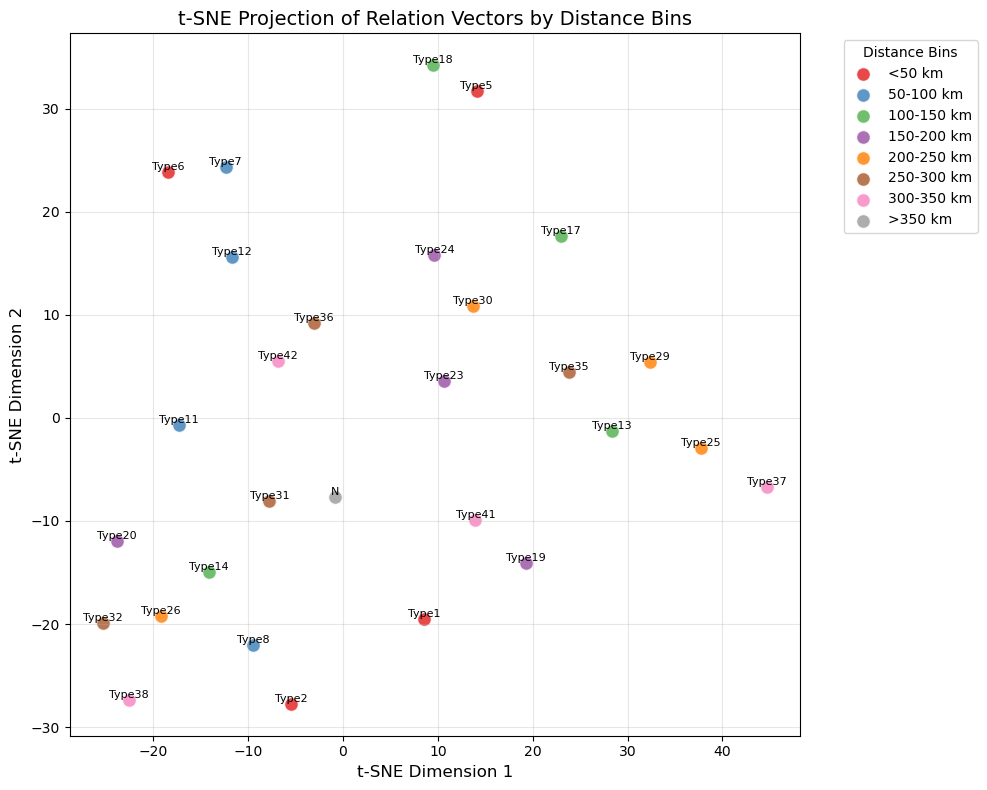

In [19]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import torch
import pickle

# 加载预训练的模型和映射
model = TransEModel(num_entities, num_relations, embedding_dim, margin)
model.load_state_dict(torch.load('best_transe_model.pth'))

# 加载关系映射表
with open('relation2id.pkl', 'rb') as f:
    relation2id = pickle.load(f)
id2relation = {v: k for k, v in relation2id.items()}  # 反转映射

# 提取所有关系向量 (PyTorch Embedding层)
relation_embeddings = model.relation_embeddings.weight.data.cpu().numpy()

# 根据关系名称分配距离区间标签
distance_bins = []
for rel_id in range(len(relation2id)):
    rel_name = id2relation[rel_id]
    if rel_name.startswith("Type"):
        type_num = int(rel_name[4:])
        if 1 <= type_num <= 6:
            bin_label = "<50 km"
        elif 7 <= type_num <= 12:
            bin_label = "50-100 km"
        elif 13 <= type_num <= 18:
            bin_label = "100-150 km"
        elif 19 <= type_num <= 24:
            bin_label = "150-200 km"
        elif 25 <= type_num <= 30:
            bin_label = "200-250 km"
        elif 31 <= type_num <= 36:
            bin_label = "250-300 km"
        elif 37 <= type_num <= 42:
            bin_label = "300-350 km"
        else:
            bin_label = ">350 km"
    elif rel_name == "N":
        bin_label = ">350 km"
    else:
        bin_label = ">350 km"
    distance_bins.append(bin_label)

# 使用t-SNE进行降维（标准化后）
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(relation_embeddings)

tsne = TSNE(n_components=2, perplexity=7, random_state=2024)
projections = tsne.fit_transform(scaled_embeddings)

# 定义颜色和标签
color_map = {
    "<50 km": "#e41a1c",     # 红色
    "50-100 km": "#377eb8",  # 蓝色
    "100-150 km": "#4daf4a", # 绿色
    "150-200 km": "#984ea3", # 紫色
    "200-250 km": "#ff7f00", # 橙色
    "250-300 km": "#a65628", # 棕色（Coffee色）
    "300-350 km": "#f781bf", # 粉色（Pink色）
    ">350 km": "#999999"     # 灰色（Gray色）
}

# 绘制散点图
plt.figure(figsize=(10, 8))
for bin_label in color_map:
    mask = np.array(distance_bins) == bin_label
    plt.scatter(
        projections[mask, 0], projections[mask, 1],
        c=color_map[bin_label], label=bin_label,
        s=100, alpha=0.8, edgecolors='w'
    )

# 添加标注（避免重叠）
for i, (x, y) in enumerate(projections):
    plt.text(x, y, id2relation[i], fontsize=8, ha='center', va='bottom')

plt.title('t-SNE Projection of Relation Vectors by Distance Bins', fontsize=14)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.legend(title='Distance Bins', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()

# 保存图像
plt.savefig('relation_tsne.png', dpi=300, bbox_inches='tight')
plt.show()

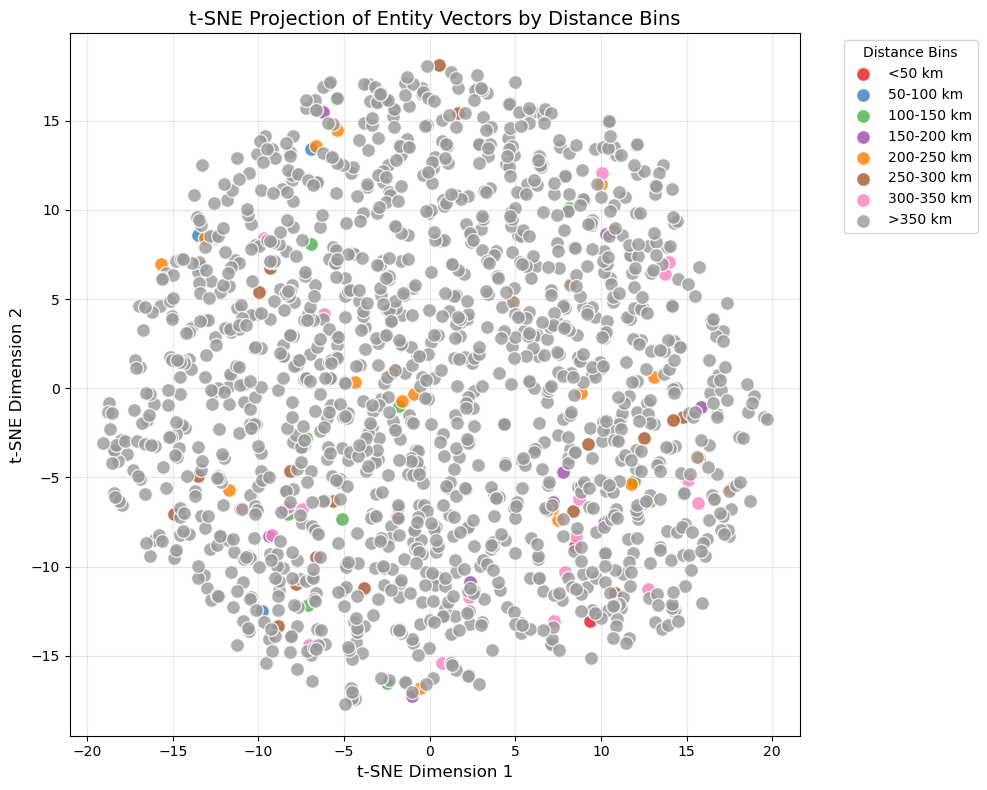

In [31]:
import re
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import torch
import pickle

# 加载预训练的模型和映射
model = TransEModel(num_entities, num_relations, embedding_dim, margin)
model.load_state_dict(torch.load('best_transe_model.pth'))

# 加载实体映射表
with open('entity2id.pkl', 'rb') as f:
    entity2id = pickle.load(f)
id2entity = {v: k for k, v in entity2id.items()}  # 反转映射

# 提取所有实体向量 (PyTorch Embedding层)
entity_embeddings = model.entity_embeddings.weight.data.cpu().numpy()

# 定义判断函数
def starts_with_number(s: str) -> bool:
    """使用正则表达式判断字符串是否以数字（含小数）开头"""
    return bool(re.match(r'^[-+]?\d+\.?\d*', s))
# 根据关系名称分配距离区间标签
distance_bins = []
for rel_id in range(len(entity2id)):
    rel_name = id2entity[rel_id]
    if starts_with_number(rel_name):
        lat1 = float(rel_name.split('_')[0])
        lon1 = float(rel_name.split('_')[1])
        lat2 = wind_farms['Farm16'][1]
        lon2 = wind_farms['Farm16'][0]
        distance = haversine(lat1, lon1, lat2, lon2)
        if distance <= 50:
            bin_label = "<50 km"
        elif 50 < distance <= 100:
            bin_label = "50-100 km"
        elif 100 < distance <= 150:
            bin_label = "100-150 km"
        elif 150 < distance <= 200:
            bin_label = "150-200 km"
        elif 200 < distance <= 250:
            bin_label = "200-250 km"
        elif 250 < distance <= 300:
            bin_label = "250-300 km"
        elif 300 < distance <= 350:
            bin_label = "300-350 km"
        else:
            bin_label = ">350 km"
    distance_bins.append(bin_label)

# 使用t-SNE进行降维（标准化后）
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(entity_embeddings)

tsne = TSNE(n_components=2, perplexity=100, random_state=2024)
projections = tsne.fit_transform(scaled_embeddings)

# 定义颜色和标签
color_map = {
    "<50 km": "#e41a1c",     # 红色
    "50-100 km": "#377eb8",  # 蓝色
    "100-150 km": "#4daf4a", # 绿色
    "150-200 km": "#984ea3", # 紫色
    "200-250 km": "#ff7f00", # 橙色
    "250-300 km": "#a65628", # 棕色（Coffee色）
    "300-350 km": "#f781bf", # 粉色（Pink色）
    ">350 km": "#999999"     # 灰色（Gray色）
}

# 绘制散点图
plt.figure(figsize=(10, 8))
for bin_label in color_map:
    mask = np.array(distance_bins) == bin_label
    plt.scatter(
        projections[mask, 0], projections[mask, 1],
        c=color_map[bin_label], label=bin_label,
        s=100, alpha=0.8, edgecolors='w'
    )

# # 添加标注（避免重叠）
# for i, (x, y) in enumerate(projections):
#     plt.text(x, y, id2relation[i], fontsize=8, ha='center', va='bottom')

plt.title('t-SNE Projection of Entity Vectors by Distance Bins', fontsize=14)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.legend(title='Distance Bins', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()

# 保存图像
plt.savefig('entity_tsne.png', dpi=300, bbox_inches='tight')
plt.show()


